In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import time
import copy
import random
import cv2
import re
import shutil
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
#extract list of images in the folders
base_dir = os.getcwd()
crack_images_path = os.path.join(base_dir, 'drive', 'My Drive', 'Crack_detection', 'training', 'positive')
no_crack_images_path = os.path.join(base_dir, 'drive', 'My Drive', 'Crack_detection', 'training', 'negative')

crack_fnames = os.listdir(crack_images_path)
print("Number of crack images: ", len(crack_fnames))
no_crack_fnames = os.listdir(no_crack_images_path)
print("Number of no crack images: ", len(no_crack_fnames))

Number of crack images:  16000
Number of no crack images:  16000


------------crack images--------------


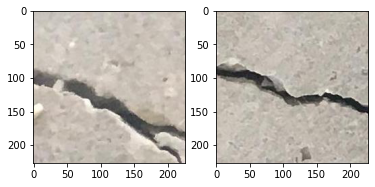

In [ ]:
# Visualize random crack images
random_numbers = np.random.randint(0, len(crack_fnames), size=2)
random_images = np.array(crack_fnames)[random_numbers.astype(int)]
print("------------crack images--------------")
f, ax = plt.subplots(1,2)
ax[0].imshow(mpimg.imread(os.path.join(crack_images_path, random_images[0])))
ax[1].imshow(mpimg.imread(os.path.join(crack_images_path, random_images[1])))

------------images without crack--------------


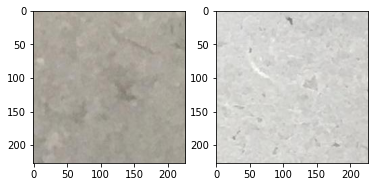

In [ ]:
# Visualize random images without crack
random_numbers = np.random.randint(0, len(no_crack_fnames), size=2)
random_images = np.array(no_crack_fnames)[random_numbers.astype(int)]
print("------------images without crack--------------")
f, ax = plt.subplots(1,2)
ax[0].imshow(mpimg.imread(os.path.join(no_crack_images_path, random_images[0])))
ax[1].imshow(mpimg.imread(os.path.join(no_crack_images_path, random_images[1])))

In [ ]:
#create training and validation datasets
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    fnames = os.listdir(SOURCE)
    fnames_filtered = []
    for fname in fnames:
        path = os.path.join(SOURCE, fname)
        if os.path.getsize(path) != 0:
            fnames_filtered.append(fname)
    fnames_shuffled = random.sample(fnames_filtered, len(fnames_filtered))
    size = int(SPLIT_SIZE*len(fnames_filtered))
    train_data = fnames_shuffled[:size]
    test_data = fnames_shuffled[size:]
    for item in train_data:
        source = os.path.join(SOURCE, item)
        destination = os.path.join(TRAINING, item)
        shutil.copyfile(source, destination)
    for file in test_data:
        source = os.path.join(SOURCE, file)
        destination = os.path.join(TESTING, file)
        shutil.copyfile(source, destination)

positive_source_dir = os.path.join(base_dir, 'dataset', 'Positive')
negative_source_dir = os.path.join(base_dir, 'dataset', 'Negative')
train_positive_dir = os.path.join(base_dir, 'crack-v-no_crack', 'training', 'positive')
train_negative_dir = os.path.join(base_dir, 'crack-v-no_crack', 'training', 'negative')
val_positive_dir = os.path.join(base_dir, 'crack-v-no_crack', 'validation', 'positive')
val_negative_dir = os.path.join(base_dir, 'crack-v-no_crack', 'validation', 'negative')
split_size = .8
split_data(positive_source_dir, train_positive_dir, val_positive_dir, split_size)

In [ ]:
split_data(negative_source_dir, train_negative_dir, val_negative_dir, split_size)
print(len(os.listdir(train_positive_dir)))
print(len(os.listdir(val_positive_dir)))
print(len(os.listdir(train_negative_dir)))
print(len(os.listdir(val_negative_dir)))

16000
4000
16000
4000


In [ ]:
# Create an instance of the inception model from the local pre-trained weights
local_weights_file = os.path.join(base_dir, 'drive', 'My Drive', 'Crack_detection', 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(input_shape = (227, 227, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False
  
# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 113, 113, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 113, 113, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 113, 113, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 12, 12, 768)


In [ ]:
# Define a Callback class that stops training once training accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') is not None and logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer
x = layers.Flatten()(last_output)
# Add a fully connected layer with 128 hidden units with ReLU activation
x = layers.Dense(128, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 113, 113, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 113, 113, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 113, 113, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_dir = os.path.join(base_dir, 'drive', 'My Drive', 'Crack_detection', 'training')
validation_dir = os.path.join(base_dir, 'drive', 'My Drive', 'Crack_detection', 'validation')
# Add data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode='nearest')

# rescale validation images
val_datagen = ImageDataGenerator( rescale = 1./255. )

# Flow training images in batches of 64 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 64,
                                                    class_mode = 'binary', 
                                                    target_size = (227, 227))     

# Flow validation images in batches of 64 using test_datagen generator
validation_generator =  val_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 64,
                                                          class_mode  = 'binary', 
                                                          target_size = (227, 227))

Found 32000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


In [ ]:
callbacks = myCallback()
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 10,
            verbose = 2,
            callbacks=[callbacks])

Epoch 1/10
500/500 - 414s - loss: 0.0295 - accuracy: 0.9912 - val_loss: 0.0149 - val_accuracy: 0.9966
Epoch 2/10
500/500 - 413s - loss: 0.0199 - accuracy: 0.9949 - val_loss: 0.0103 - val_accuracy: 0.9980
Epoch 3/10
500/500 - 409s - loss: 0.0204 - accuracy: 0.9952 - val_loss: 0.0105 - val_accuracy: 0.9980
Epoch 4/10
500/500 - 409s - loss: 0.0205 - accuracy: 0.9949 - val_loss: 0.0069 - val_accuracy: 0.9985
Epoch 5/10
500/500 - 408s - loss: 0.0175 - accuracy: 0.9959 - val_loss: 0.0094 - val_accuracy: 0.9981
Epoch 6/10
500/500 - 408s - loss: 0.0184 - accuracy: 0.9960 - val_loss: 0.0064 - val_accuracy: 0.9983
Epoch 7/10
500/500 - 408s - loss: 0.0199 - accuracy: 0.9959 - val_loss: 0.0097 - val_accuracy: 0.9980
Epoch 8/10
500/500 - 408s - loss: 0.0156 - accuracy: 0.9960 - val_loss: 0.0070 - val_accuracy: 0.9987
Epoch 9/10
500/500 - 408s - loss: 0.0172 - accuracy: 0.9967 - val_loss: 0.0070 - val_accuracy: 0.9983
Epoch 10/10
500/500 - 408s - loss: 0.0167 - accuracy: 0.9957 - val_loss: 0.0103 - 

[0.9911562204360962, 0.9949374794960022, 0.9952499866485596, 0.9949374794960022, 0.9959375262260437, 0.995968759059906, 0.9959375262260437, 0.9959999918937683, 0.9966562390327454, 0.9956562519073486]
[0.9966250061988831, 0.9980000257492065, 0.9980000257492065, 0.9984999895095825, 0.9981250166893005, 0.9982500076293945, 0.9980000257492065, 0.9987499713897705, 0.9982500076293945, 0.9981250166893005]


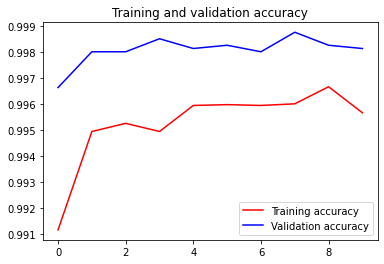

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
print(acc)
val_acc = history.history['val_accuracy']
print(val_acc)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
# predicting images using image as input
from tensorflow.keras.preprocessing import image

def predict_image(model, test_image, print_class=False):
    '''predict the test image
    input: model, test_image(raw image), print_class(boolean)
    output: the predicted class(str)'''
    path = os.path.join(os.getcwd(), 'test_images', test_image)
    #test_fnames = os.listdir(test_dir)
    #for fname in test_fnames:
        #path = os.path.join(test_dir, fname)
    img = image.load_img(path, target_size=(227, 227))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x/255.
    classes = model.predict(x)
    print(classes)
    if classes[0]>0.5:
        class_name = 'crack'
    else:
        class_name = 'no crack'
    if print_class:
        print(class_name)
    return class_name

predict(model, '06704.jpg',print_class = True)   

[[1.0881149e-06]]
no crack


'no crack'

In [ ]:
model.save('trained_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: trained_model/assets


In [ ]:
!zip -r /content/file.zip /content/trained_model

  adding: content/trained_model/ (stored 0%)
  adding: content/trained_model/assets/ (stored 0%)
  adding: content/trained_model/saved_model.pb (deflated 93%)
  adding: content/trained_model/variables/ (stored 0%)
  adding: content/trained_model/variables/variables.data-00000-of-00001 (deflated 15%)
  adding: content/trained_model/variables/variables.index (deflated 78%)


In [ ]:
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
model = tf.keras.models.load_model('trained_model')
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 113, 113, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 113, 113, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 113, 113, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

                                                                 activation_25[0][0]              
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 26, 26, 64)   18432       mixed2[0][0]                     
__________________________________________________________________________________________________
batch_normalization_27 (BatchNo (None, 26, 26, 64)   192         conv2d_27[0][0]                  
__________________________________________________________________________________________________
activation_27 (Activation)      (None, 26, 26, 64)   0           batch_normalization_27[0][0]     
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 26, 26, 96)   55296       activation_27[0][0]              
__________________________________________________________________________________________________
batch_norm

__________________________________________________________________________________________________
average_pooling2d_5 (AveragePoo (None, 12, 12, 768)  0           mixed5[0][0]                     
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 12, 12, 192)  147456      mixed5[0][0]                     
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 12, 12, 192)  215040      activation_52[0][0]              
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 12, 12, 192)  215040      activation_57[0][0]              
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 12, 12, 192)  147456      average_pooling2d_5[0][0]        
__________

In [12]:
# Select mode of optimization
mode = " " 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [13]:
# Convert to tensorflow lite model
converter = tf.lite.TFLiteConverter.from_saved_model('trained_model')

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [15]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

23215104

In [3]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()
# Get input and output tensors.
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [5]:
#predict a single image using tf.lite interpreter
def predict_tlite_one(img, print_class=False):
    '''predict the test image
    input: model, test_image(raw image), print_class(boolean)
    output: the predicted class(str)'''
    #img = np.expand_dims(img, axis=0)
    #img = np.divide(img, 255.)
    input_data = np.array(img, dtype=np.float32)
    interpreter.set_tensor(input_index, input_data)
    interpreter.invoke()
    classes = interpreter.get_tensor(output_index)
    print(classes)
    if classes[0]>0.5:
        class_name = 'Positive'
    else:
        class_name = 'Negative'
    if print_class:
        print(class_name)
    return class_name

#test_image = '06732.jpg'
#path = os.path.join(os.getcwd(), 'test_images', test_image)
#img = cv2.imread(path)
#predict_tlite_one(img, print_class=True)

In [7]:
def predict_tlite_real(input_image, height=227, width=227, save_crops = False):
    path = os.path.join(os.getcwd(), 'real_images', input_image)
    img = cv2.imread(path)
    img_height, img_width, channels = img.shape
    output_image = np.zeros_like(img)
    k=0
    if img_height > 1500:
        slide_h = height
    else:
        slide_h = 113
    if img_width > 1500:
        slide_w = width
    else:
        slide_w = 113
    for i in range(0,img_height,slide_h):
        for j in range(0,img_width,slide_w):
            a = img[i:i+height, j:j+width]
            h, w, c = a.shape
            if h == 227 and w == 227: 
                a_input = np.expand_dims(a, axis=0)
                a_input = a_input/255.
                predicted_class = predict_tlite_one(a_input)
            ## save image
                file, ext = os.path.splitext(input_image)
                image_name = file.split('/')[-1]
                folder_name = 'out_' + image_name
            ## Put predicted class on the cropped image
                if predicted_class == 'Positive':
                    color = (0,0, 255)
                else:
                    color = (0, 255, 0)
                cv2.putText(a, predicted_class, (50,50), cv2.FONT_HERSHEY_SIMPLEX , 0.7, color, 1, cv2.LINE_AA) 
            #b = np.zeros_like(a, dtype=np.uint8)
                b = np.zeros_like(a)
                b[:] = color
                add_img = cv2.addWeighted(a, 0.9, b, 0.1, 0)
            ## Save crops
                if save_crops:
                    if not os.path.exists(os.path.join('real_images', folder_name)):
                        os.makedirs(os.path.join('real_images', folder_name))
                    filename = os.path.join('real_images', folder_name,'img_{}.png'.format(k))
                    cv2.imwrite(filename, add_img)
                output_image[i:i+height, j:j+width,:] = add_img
                k+=1
    ## Save output image
    cv2.imwrite(os.path.join('real_images','predictions', folder_name+ '.jpg'), output_image)
    return output_image

predict_tlite_real('lab_crack1.jpg')

[[3.2939217e-05]]
[[1.]]
[[0.00159162]]
[[4.0574105e-06]]
[[8.836265e-06]]
[[0.00222543]]
[[5.655026e-06]]
[[0.0014922]]
[[3.2364635e-06]]
[[5.504646e-05]]
[[6.3858606e-05]]
[[4.08221e-05]]
[[0.00072664]]
[[0.00045225]]
[[1.]]
[[0.00034928]]
[[2.744117e-06]]
[[3.0113733e-07]]
[[8.6105706e-07]]
[[5.4596185e-06]]
[[0.00029474]]
[[3.330811e-05]]
[[1.1111374e-05]]
[[1.35560285e-05]]
[[0.00020406]]
[[9.672201e-05]]
[[3.2318356e-05]]
[[0.9999868]]
[[0.00013158]]
[[0.00013834]]
[[7.261519e-05]]
[[0.00014016]]
[[0.00040489]]
[[9.099316e-06]]
[[0.00049928]]
[[4.9625392e-05]]
[[6.335289e-05]]
[[0.00034976]]
[[0.0011645]]
[[5.7701372e-06]]
[[1.]]
[[3.8919672e-05]]
[[0.00036937]]
[[0.00016052]]
[[0.00194415]]
[[1.6932081e-05]]
[[6.9693364e-05]]
[[0.00062612]]
[[8.25569e-06]]
[[4.318677e-05]]
[[1.5933289e-05]]
[[3.9456183e-05]]
[[7.882624e-06]]
[[1.]]
[[0.0118874]]
[[1.5622718e-06]]
[[0.00484413]]
[[5.5248915e-06]]
[[0.00028133]]
[[0.00016123]]
[[9.1801553e-07]]
[[1.7476112e-05]]
[[0.00106183]]
[[7

array([[[209, 230, 202],
        [208, 229, 201],
        [208, 229, 201],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[184, 206, 177],
        [190, 211, 183],
        [198, 219, 191],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[172, 193, 165],
        [178, 199, 171],
        [187, 208, 180],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [42]:
input_image = 'road_surface_crack2.jpg'
path = os.path.join(os.getcwd(), 'real_images', input_image)
img = cv2.imread(path)
img_height, img_width, channels = img.shape
for i in range(0,img_height,500):
    for j in range(0,img_width,500):
        a = img[i:i+500, j:j+500]
        print(a)

[[[151 153 153]
  [138 140 140]
  [167 169 169]
  ...
  [166 168 168]
  [154 156 156]
  [175 177 177]]

 [[143 145 145]
  [132 134 134]
  [128 130 130]
  ...
  [158 160 160]
  [153 155 155]
  [149 151 151]]

 [[157 159 159]
  [157 159 159]
  [132 134 134]
  ...
  [159 161 161]
  [143 145 145]
  [145 147 147]]

 ...

 [[ 60  62  62]
  [115 117 117]
  [127 129 129]
  ...
  [147 151 152]
  [133 137 138]
  [ 77  81  82]]

 [[121 123 123]
  [119 121 121]
  [ 75  77  77]
  ...
  [110 114 115]
  [134 138 139]
  [157 161 162]]

 [[ 92  94  94]
  [ 97  99  99]
  [ 94  96  96]
  ...
  [186 190 191]
  [121 125 126]
  [143 147 148]]]
[[[171 173 173]
  [148 150 150]
  [170 172 172]
  ...
  [209 213 214]
  [112 114 115]
  [101 103 104]]

 [[145 147 147]
  [155 157 157]
  [188 190 190]
  ...
  [135 139 140]
  [141 143 144]
  [130 132 133]]

 [[142 144 144]
  [137 139 139]
  [160 162 162]
  ...
  [179 183 184]
  [175 177 178]
  [165 167 168]]

 ...

 [[ 74  78  79]
  [115 119 120]
  [192 196 197]
  ..

In [4]:
# predicting images using single image as input (tensorflow)
from tensorflow.keras.preprocessing import image

def predict(model, img, print_class=False):
    '''predict the test image
    input: model, test_image(raw image), print_class(boolean)
    output: the predicted class(str)'''
    #path = os.path.join(os.getcwd(), 'test_images', test_image)
    #test_fnames = os.listdir(test_dir)
    #for fname in test_fnames:
        #path = os.path.join(test_dir, fname)
    #img = image.load_img(path, target_size=(227, 227))
    #x = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img/255.
    classes = model.predict(img)
    print(classes)
    if classes[0]>0.5:
        class_name = 'Positive'
    else:
        class_name = 'Negative'
    if print_class:
        print(class_name)
    return class_name

In [5]:
test_image = '12759_1.jpg'
path = os.path.join(os.getcwd(), 'test_images', test_image)
img = image.load_img(path, target_size=(227, 227))
img = image.img_to_array(img)
predict(model, img,print_class = True) 

[[1.]]
Positive


'Positive'

In [9]:
def predict_real_image(input_image, height=227, width=227, save_crops = False):
    path = os.path.join(os.getcwd(), 'real_images', input_image)
    img = cv2.imread(path)
    img_height, img_width, channels = img.shape
    output_image = np.zeros_like(img)
    k=0
    if img_height > 1500:
        slide_h = height
    else:
        slide_h = 113
    if img_width > 1500:
        slide_w = width
    else:
        slide_w = 113
    for i in range(0,img_height,slide_h):
        for j in range(0,img_width,slide_w):
            a = img[i:i+height, j:j+width]
            h, w, c = a.shape
            if h == 227 and w == 227:           
                predicted_class = predict(model,a)
            ## save image
                file, ext = os.path.splitext(input_image)
                image_name = file.split('/')[-1]
                folder_name = 'out_' + image_name
            ## Put predicted class on the cropped image
                if predicted_class == 'Positive':
                    color = (0,0, 255)
                else:
                    color = (0, 255, 0)
                cv2.putText(a, predicted_class, (50,50), cv2.FONT_HERSHEY_SIMPLEX , 0.7, color, 1, cv2.LINE_AA) 
            #b = np.zeros_like(a, dtype=np.uint8)
                b = np.zeros_like(a)
                b[:] = color
                add_img = cv2.addWeighted(a, 0.9, b, 0.1, 0)
            ## Save crops
                if save_crops:
                    if not os.path.exists(os.path.join('real_images', folder_name)):
                        os.makedirs(os.path.join('real_images', folder_name))
                    filename = os.path.join('real_images', folder_name,'img_{}.png'.format(k))
                    cv2.imwrite(filename, add_img)
                output_image[i:i+height, j:j+width,:] = add_img
                k+=1
    ## Save output image
    cv2.imwrite(os.path.join('real_images','predictions', folder_name+ '.jpg'), output_image)
    return output_image

In [10]:
predict_real_image('road_surface_crack3.jpg')

[[0.09264645]]
[[3.600861e-09]]
[[1.1007433e-05]]
[[0.00018811]]
[[7.084886e-06]]
[[4.2077218e-07]]
[[0.6217654]]
[[0.00091079]]
[[1.0500732e-05]]
[[0.00131804]]
[[2.1525155e-05]]
[[7.953147e-05]]
[[0.99998945]]
[[0.23615482]]
[[9.506577e-07]]
[[1.8591552e-07]]
[[2.6908046e-06]]
[[0.17399812]]
[[0.94767785]]
[[0.9998009]]
[[0.9999994]]
[[1.]]
[[1.]]
[[0.9999967]]
[[0.0031237]]
[[2.3810342e-05]]
[[7.750734e-06]]
[[1.]]
[[0.99998]]
[[1.]]
[[0.9999928]]
[[5.3160926e-05]]
[[4.167769e-05]]
[[1.0092174e-06]]
[[0.9999998]]
[[0.00035664]]
[[1.]]
[[0.9975968]]
[[4.770994e-05]]
[[6.0750773e-07]]
[[1.9623049e-06]]
[[0.9999993]]
[[0.00029472]]
[[1.]]
[[0.00144964]]
[[4.557438e-06]]
[[1.1610726e-06]]
[[1.1361499e-06]]
[[1.]]
[[3.5401245e-06]]
[[1.]]
[[0.00016415]]
[[1.5978252e-05]]
[[1.313006e-05]]
[[0.00044844]]
[[0.9999987]]
[[0.00019249]]
[[0.00132585]]
[[0.00916579]]
[[9.562408e-05]]
[[0.00116554]]
[[0.00256845]]
[[0.99999464]]


array([[[155.7, 181.2, 153.9],
        [155.7, 181.2, 153.9],
        [156.6, 182.1, 154.8],
        ...,
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ]],

       [[158.4, 183.9, 158.4],
        [157.5, 183. , 157.5],
        [157.5, 183. , 157.5],
        ...,
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ]],

       [[155.7, 181.2, 155.7],
        [154.8, 180.3, 154.8],
        [155.7, 181.2, 155.7],
        ...,
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ]],

       ...,

       [[  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ],
        ...,
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ]],

       [[  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ],
        ...,
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ],
        [  0. ,